<center>
    <tr>
    <td><img src="ontario-tech-univ-logo.png" width="25%"></img></td>
    </tr>
</center>

# SIFT like local features

Faisal Qureshi   
Professor    
Faculty of Science    
Ontario Tech University    
Oshawa ON Canada    
http://vclab.science.ontariotechu.ca

# Copyright information
© Faisal Qureshi

# License

This work is licensed under a [Creative Commons Attribution-NonCommercial 4.0 International License.](https://creativecommons.org/licenses/by-nc/4.0/)

# Outline
* Image derivatives
* Image gradients
* Gradient magnitudes and angles
* Quantization
* Histogram computation

# Tasks
### 1
Complete the various steps needed to compute the rotation invariant descriptor. You can use the following image to test your code

```python
DATA_FOLDER = 'data'
img = cv.imread(os.path.join(DATA_FOLDER, 'local-features-construction-2.jpg'), 0)
img = cv.resize(img, (256, 256))

plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray');
plt.plot([74],[175],'r.')
```

### 2
Combine this code in the following method

<code>descriptor, I_patch, grad_patch, grad_patch_weighted, grad_color_patch = my_local_descriptor(img, r, c)</code>

This method takes in an image <code>img</code> and row <code>r</code> and column <code>c</code> location. The method returns a 128-dimensional descriptor. It should also return  4   16×16  patches around <code>(r,c)</code> locations. <code>I_patch</code> is image intensity patch, <code>grad_patch</code> is gradient magnitudes, <code>grad_patch_weighted</code> is weighted gradient magnitudes, and <code>grad_color_patch</code> returns the colorized gradient magnitudes.

### 3
Use this method to compute descriptors as follows:

```python
DATA_FOLDER = 'data'
img1 = cv.imread(os.path.join(DATA_FOLDER, 'local-features-construction-2.jpg'), 0)
img1 = cv.resize(img1, (256, 256))

img2 = cv.imread(os.path.join(DATA_FOLDER, 'local-features-construction-1.jpg'), 0)
img2 = cv.resize(img2, (256, 256))

desc1, p1, g1, gw1, gc1 = my_local_descriptor(img1, 175, 74)
desc2, p2, g2, gw2, gc2 = my_local_descriptor(img2, 197, 106) 
desc3, p3, g3, gw3, gc3 = my_local_descriptor(img2, 100, 54)
```

### 4
Next compute the distances between the three descriptors as follows:

```python
X = np.vstack([desc1, desc2, desc3])

from scipy.spatial import distance_matrix
distance_matrix(X, X)
```

### 5
Comment whether or not desc1 is closer to desc2 than to desc3.

# Starter code

In [236]:
import cv2 as cv
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import scipy.stats as st

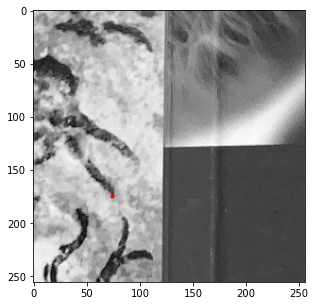

In [237]:
DATA_FOLDER = 'data'
img = cv.imread(os.path.join(DATA_FOLDER, 'local-features-construction-2.jpg'), 0)
img = cv.resize(img, (256, 256))

plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.plot([74],[175],'r.');

## Image derivatives

In [238]:
# %load solutions/05-sift-like-local-features/lab-5-solution-image-derivatives.py
Ix = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
Iy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=5)
Igrad = np.sqrt(np.power(Ix, 2) + np.power(Iy, 2))
Iangle = np.arctan2(Ix, Iy)

def colorize_gradient_orientation(g, sobelx, sobely):
    hsv = np.zeros([g.shape[0], g.shape[0],3], dtype=np.uint8)
    hsv[..., 1] = 255
    
    mag, ang = cv.cartToPolar(sobelx[...], sobely[...])
    hsv[..., 0] = (ang * 180 / np.pi / 2)
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    gc = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    
    return gc
Igrad_color = colorize_gradient_orientation(Igrad, Ix, Iy)

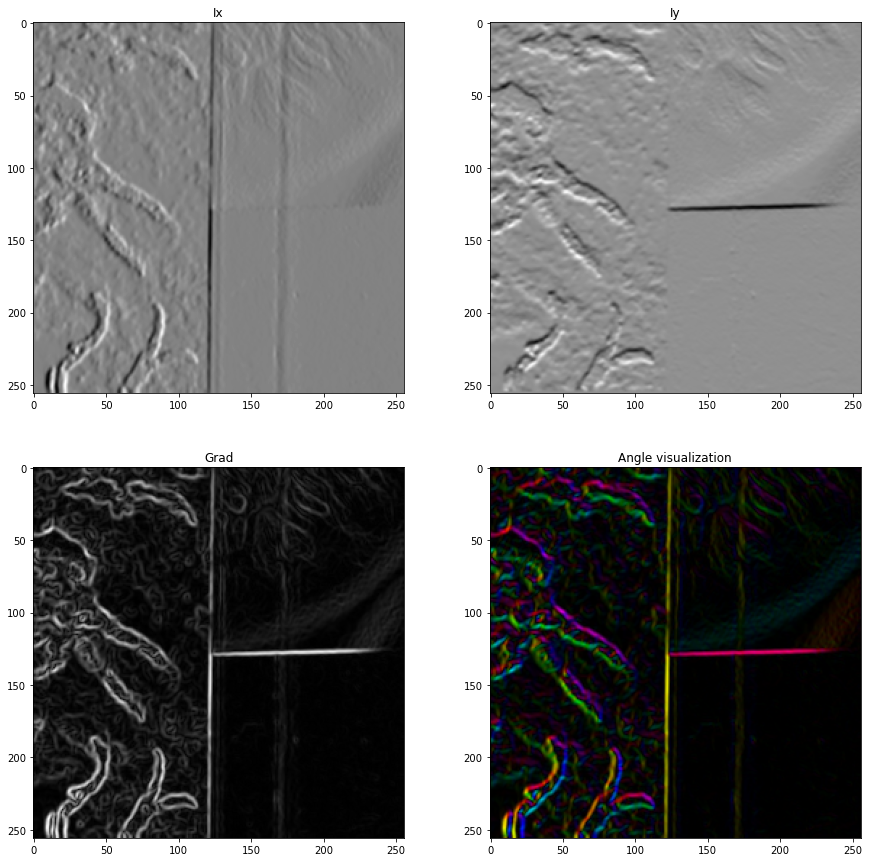

In [239]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Ix')
plt.imshow(Ix, cmap='gray')
plt.subplot(222)
plt.title('Iy')
plt.imshow(Iy, cmap='gray');
plt.subplot(223)
plt.title('Grad')
plt.imshow(Igrad, cmap='gray')
plt.subplot(224)
plt.title('Angle visualization')
plt.imshow(Igrad_color);

## 16x16 window patch

Extract a  16𝑥16  window around location  (𝑥,𝑦) . Notice how images are stored in numpy. Unlike the 2D  𝑥𝑦  coordinate system that we are used to, here  𝑥  corresponds to columns and increase from left to right.  𝑦  corresponds to rows and increase from top to bottom.

In [240]:
# %load solutions/05-sift-like-local-features/lab-5-solution-patch.py
def patch(I, r, c, w=8, h=8):
    """
    Extracts the region around location (r,c) --- row, column --- of width 2+w and height 2+h.
    Rows go from top to bottom and represent the first dimension. Columns go from left to right
    and represent the second dimension
    """
    I_patch = I[r-h:r+h, c-w:c+w]
    return I_patch
r, c = 175, 74
grad_patch = patch(Igrad, r, c, w=8, h=8)

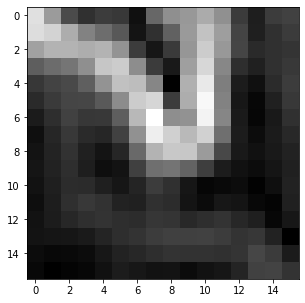

In [241]:
plt.figure(figsize=(5,5))
plt.imshow(grad_patch, cmap='gray');

## Weighted gradient magnitudes
Get gradient magnitude and multiply it by a  16×16  Gaussian window of  𝜎=2.5 

In [242]:
# %load solutions/05-sift-like-local-features/lab-5-solution-weighted-grad.py
import scipy.stats as st

def gaussiankernel(kernlen=5, sig=3):
    """Returns a 2D Gaussian Kernel"""
    
    x = np.linspace(-kernlen/(3*sig), kernlen/(3*sig), kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

g = gaussiankernel(kernlen=16, sig=2.5)
#print(g.shape)
grad_patch_weighted = g * grad_patch

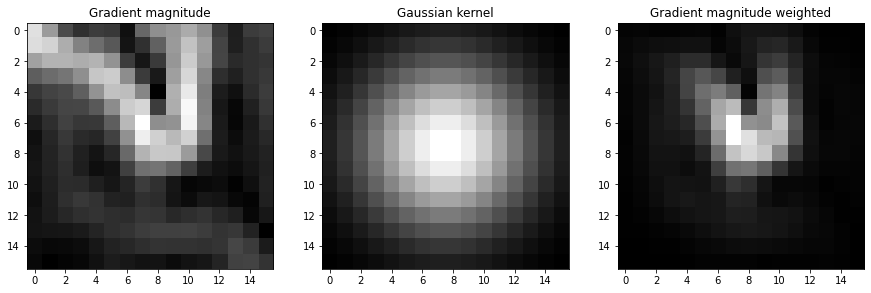

In [243]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Gradient magnitude')
plt.imshow(grad_patch, cmap='gray')
plt.subplot(132)
plt.title('Gaussian kernel')
plt.imshow(g, cmap='gray')
plt.subplot(133)
plt.title('Gradient magnitude weighted')
plt.imshow(grad_patch_weighted, cmap='gray');

## Finding dominant angle
Quantize angles to 36 bins (from 0 to 360 degrees). Find the dominant angle (the angle that is most repeated). Subtract dominant angle from every angle to achieve rotation invariant.

In [226]:
# %load solutions/05-sift-like-local-features/lab-5-solution-dominant-angle.py
angles_patch = 180.0 + patch(Iangle, r, c, w=8, h=8) * 180.0 / np.pi
print('Check to see shape of angles patch:- ',angles_patch.shape, '\n')
print('Check to see angles of first four:\n',angles_patch[:4,:4], '\n')

bins36 = np.linspace(0, 360, 36+1)
print('bin36:\n', bins36, '\n')

angles_quantized36 = np.digitize(angles_patch, bins36)
print('Check to see the bins of first four:\n',angles_quantized36[:4,:4], '\n')

'''Finding dominant direction'''

counts = np.bincount(angles_quantized36.flatten())
print('counts = ',counts)
dominant_angle = bins36[np.argmax(counts)]
print(f'dominant angle = {dominant_angle}', '\n')

angles_patch_rotated = angles_patch - dominant_angle
bins8 = np.linspace(0, 360, 8+1)
print('bins8:\n',bins8)

'''Bin angles into 8 bins'''
angles_quantized8 = np.digitize(angles_patch_rotated, bins8)

#There must be a way oto avoid this for-loop
for i in range(16):
    for j in range(16):
        angles_quantized8[i,j] = bins8[angles_quantized8[i,j]]

Check to see shape of angles patch:-  (16, 16) 

Check to see angles of first four:
 [[121.5637969  132.17953239 170.19442561 181.40967874]
 [130.43118092 145.42598321 165.61196912 164.71402023]
 [132.54308137 148.69331117 161.57665421 153.2813412 ]
 [128.128263   145.5411321  152.89925699 142.01254581]] 

bin36:
 [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360.] 

Check to see the bins of first four:
 [[13 14 18 19]
 [14 15 17 17]
 [14 15 17 16]
 [13 15 16 15]] 

counts =  [ 0  1  0  0  0  0  0  1  0  1  3 10 13 31 29 24 19 10 10 11  5  2  6  1
  3  4  7 13 13 16  9  6  5  3]
dominant angle = 130.0 

bins8:
 [  0.  45.  90. 135. 180. 225. 270. 315. 360.]


## Construct feature descriptor
Divide  16×16  into  16  blocks. Each block is  4×4 . Within each block, quantize angles into 8 bins (from 0 to 360 degrees). Computed gradient magnitude weighted, normalized, angle histograms. Each block thus returns an  8 -dimensional vector. Concatenate  16   8 -dimensional vectors to construct a  128 -dimensional vector.

In [264]:
# %load solutions/05-sift-like-local-features/lab-5-solution-feature-descriptor.py
from scipy.spatial import distance
'''Divide 16 by 16 grid 16 four by four cells/sub-group,
Compute histogram
take angles and bins
Compute weights and do density
So for each four by four sub-patch, an 8 dimensional vector will be appended'''
descriptor = np.empty(128)
k = 0
for r in range(4):
    for c in range(4):
        angles = angles_quantized8[r*4:r*4+4, c*4:c*4+4]
        weights = grad_patch_weighted[r*4:r*4+4, c*4:c*4+4]
        h, _ = np.histogram(angles[::], bins8, weights=weights, density=True)
        descriptor[k:k+8] = h
        k = k + 8
print('descriptor:\n',descriptor)

descriptor:
 [0.00114651 0.02070279 0.00037293 0.         0.         0.
 0.         0.         0.00474722 0.01551184 0.00046756 0.
 0.00061233 0.00088327 0.         0.         0.         0.
 0.         0.         0.02143869 0.00078353 0.         0.
 0.         0.         0.         0.         0.01687031 0.00535191
 0.         0.         0.01513103 0.00709119 0.         0.
 0.         0.         0.         0.         0.01463791 0.00758431
 0.         0.         0.         0.         0.         0.
 0.00227667 0.00248937 0.00206996 0.00510652 0.0102797  0.
 0.         0.         0.         0.         0.         0.00983296
 0.01238926 0.         0.         0.         0.01488545 0.00733678
 0.         0.         0.         0.         0.         0.
 0.00623894 0.01515431 0.00082898 0.         0.         0.
 0.         0.         0.00107278 0.00867659 0.01118786 0.00128499
 0.         0.         0.         0.         0.         0.0007277
 0.00190752 0.01405827 0.00552873 0.         0.        

## Putting it all together
Now put the code together in one convenient function that computes the 128 dimensional descriptor at a particular location of a given grayscale image.

In [252]:
# %load solutions/05-sift-like-local-features/lab-5-solution-my-local-descriptor.py
def my_local_descriptor(img, r, c):
    Ix = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
    Iy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=5)
    Igrad = np.sqrt(np.power(Ix, 2) + np.power(Iy, 2))
    Iangle = np.arctan2(Ix, Iy)
    
    def colorize_gradient_orientation(g, sobelx, sobely):
        hsv = np.zeros([g.shape[0], g.shape[0],3], dtype=np.uint8)
        hsv[..., 1] = 255

        mag, ang = cv.cartToPolar(sobelx[...], sobely[...])
        hsv[..., 0] = (ang * 180 / np.pi / 2)
        hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
        gc = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

        return gc
    Igrad_color = colorize_gradient_orientation(Igrad, Ix, Iy)
    
    
    def patch(I, r, c, w=8, h=8):
        I_patch = I[r-h:r+h, c-w:c+w]
        return I_patch
    I_patch = patch(img, r, c, w=8, h=8)
    grad_patch = patch(Igrad, r, c, w=8, h=8)
    grad_color_patch = patch(Igrad_color, r, c, w=8, h=8)
    
    def gaussiankernel(kernlen=5, sig=3):
        x = np.linspace(-kernlen/(3*sig), kernlen/(3*sig), kernlen+1)
        kern1d = np.diff(st.norm.cdf(x))
        kern2d = np.outer(kern1d, kern1d)
        return kern2d/kern2d.sum()
    g = gaussiankernel(kernlen=16, sig=2.5)
    grad_patch_weighted = g * grad_patch
    
    angles_patch = 180.0 + patch(Iangle, r, c, w=8, h=8) * 180.0 / np.pi
    bins36 = np.linspace(0, 360, 36+1)
    angles_quantized36 = np.digitize(angles_patch, bins36)
    counts = np.bincount(angles_quantized36.flatten())
    dominant_angle = bins36[np.argmax(counts)]
    print(f'dominant angle = {dominant_angle}', '\n')
    
    angles_patch_rotated = angles_patch - dominant_angle
    bins8 = np.linspace(0, 360, 8+1)
    angles_quantized8 = np.digitize(angles_patch_rotated, bins8)
    for i in range(16):
        for j in range(16):
            angles_quantized8[i,j] = bins8[angles_quantized8[i,j]]
            
    descriptor = np.empty(128)
    k = 0
    for r in range(4):
        for c in range(4):
            angles = angles_quantized8[r*4:r*4+4, c*4:c*4+4]
            weights = grad_patch_weighted[r*4:r*4+4, c*4:c*4+4]
            h, _ = np.histogram(angles[::], bins8, weights=weights, density=True)
            descriptor[k:k+8] = h
            k = k + 8
    return descriptor, I_patch, grad_patch, grad_patch_weighted, grad_color_patch

## Check for rotation invariance

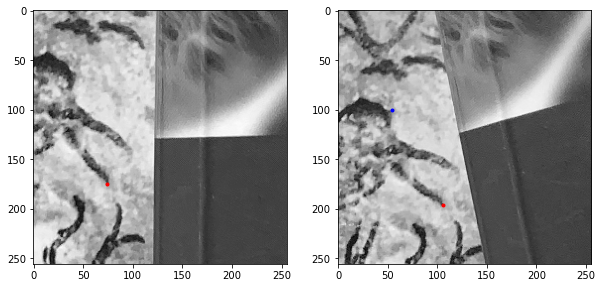

In [253]:
DATA_FOLDER = 'data'
img1 = cv.imread(os.path.join(DATA_FOLDER, 'local-features-construction-2.jpg'), 0)
img1 = cv.resize(img1, (256, 256))

img2 = cv.imread(os.path.join(DATA_FOLDER, 'local-features-construction-1.jpg'), 0)
img2 = cv.resize(img2, (256, 256))

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img1, cmap='gray');
plt.plot([74],[175],'r.')
plt.subplot(122)
plt.imshow(img2, cmap='gray');
plt.plot([106],[196],'r.');
plt.plot([54],[100],'b.');

In [254]:
desc1, p1, g1, gw1, gc1 = my_local_descriptor(img1, 175, 74)
desc2, p2, g2, gw2, gc2 = my_local_descriptor(img2, 197, 106) 
desc3, p3, g3, gw3, gc3 = my_local_descriptor(img2, 100, 54)

dominant angle = 130.0 

dominant angle = 150.0 

dominant angle = 260.0 



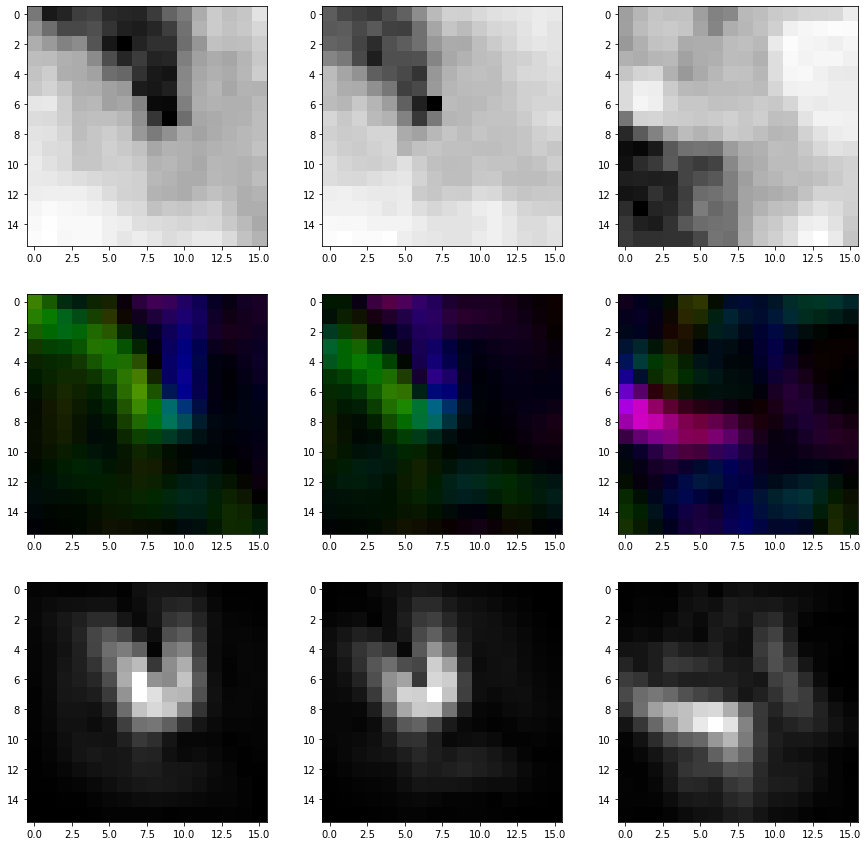

In [255]:
plt.figure(figsize=(15, 15))
plt.subplot(331)
plt.imshow(p1, cmap='gray')
plt.subplot(332)
plt.imshow(p2, cmap='gray')
plt.subplot(333)
plt.imshow(p3, cmap='gray')
plt.subplot(334)
plt.imshow(gc1, cmap='gray')
plt.subplot(335)
plt.imshow(gc2, cmap='gray')
plt.subplot(336)
plt.imshow(gc3, cmap='gray')
plt.subplot(337)
plt.imshow(gw1, cmap='gray')
plt.subplot(338)
plt.imshow(gw2, cmap='gray')
plt.subplot(339)
plt.imshow(gw3, cmap='gray');

Lets compute distance between the three descriptors, and confirm that descriptor 1,2 are closer to each other than descriptors 1,3 and 2,3.

In [279]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


print(img1.shape, '\n')
print(img2.shape, '\n')

(256, 256) 

(256, 256) 



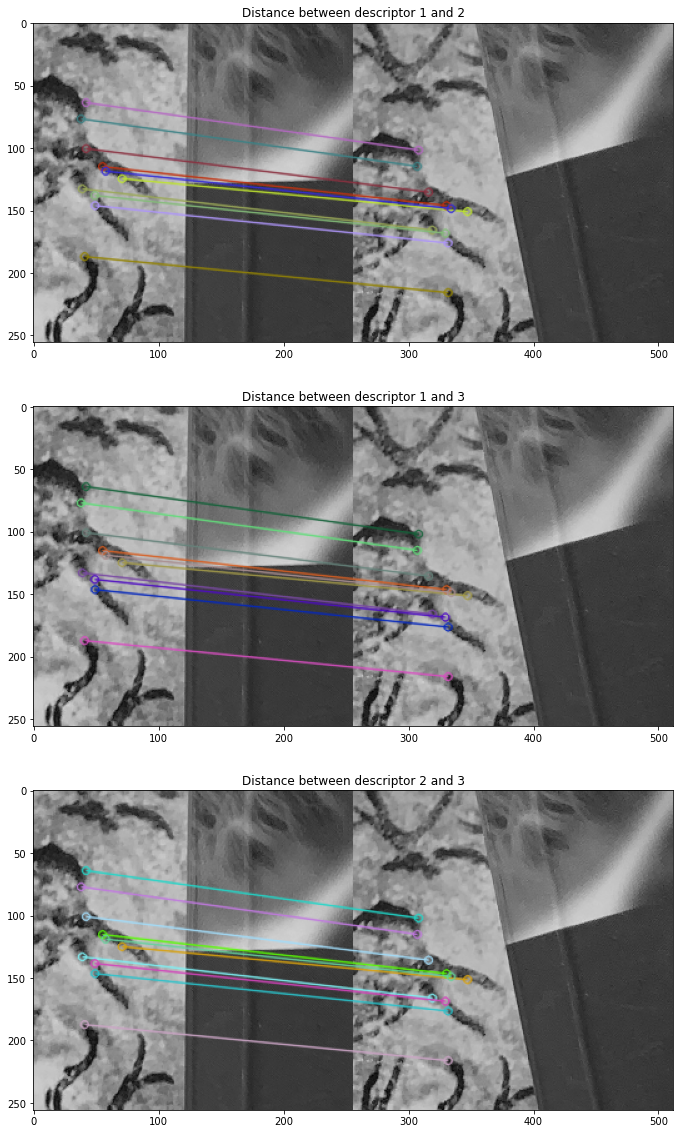

In [298]:
orb = cv.ORB_create()
p1, des1 = orb.detectAndCompute(img1, None) # locations and descriptor
p2, des2 = orb.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches1 = bf.match(des1, des2)
matches1 = sorted(matches1, key = lambda x:x.distance)
img1_2 = cv.drawMatches(img1, p1, img2, p2, matches1[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

p1, des1 = orb.detectAndCompute(img1, None) # locations and descriptor
p3, des3 = orb.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches2 = bf.match(des1, des3)
matches2 = sorted(matches2, key = lambda x:x.distance)
img1_3 = cv.drawMatches(img1, p1, img2, p3, matches2[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

p2, des2 = orb.detectAndCompute(img1, None) # locations and descriptor
p3, des3 = orb.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches3 = bf.match(des2, des3)
matches3 = sorted(matches3, key = lambda x:x.distance)
img2_3 = cv.drawMatches(img1, p2, img2, p3, matches3[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,20))
plt.subplot(311)
plt.title('Distance between descriptor 1 and 2')
plt.imshow(img1_2)
plt.subplot(312)
plt.title('Distance between descriptor 1 and 3')
plt.imshow(img1_3)
plt.subplot(313)
plt.title('Distance between descriptor 2 and 3')
plt.imshow(img2_3)

## Submission
Include code and results on the images found in the above folder in a single jupyter notebook. Submit via canvas.

<center>
    <tr>
    <td><img src="ontario-tech-univ-logo.png" width="25%"></img></td>
    </tr>
</center>